# VAR (Vector Auto-Regression) model

Vector auto-regression is a multivariate forecasting algorithm that is used when more time series influence each other. In this part I will analyse all the weather paramethers together using the vector auto-regression model. Each weather parameter has some dependency on the other ones. 

Sources: 

https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

Shahanaj Parvin and Murshida Khanam: Comparison Between ARIMA and VAR Model Regarding the Forecasting of the Price of Jute Goods in Bangladesh

https://www.aptech.com/blog/introduction-to-the-fundamentals-of-vector-autoregressive-models/#:~:text=with%20VAR%20models.-,What%20is%20a%20vector%20autoregressive%20model%3F,other%20variables%20in%20the%20system.

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dateutil import parser
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [102]:
station_id=5001
# read the .csv file into a DataFrame
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
df=pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['acquisition_timestamp'], utc=True)


# rearrange the data
new_data = df.pivot_table(index='timestamp', columns='parameter_type', values='value').reset_index()

# ensure 'acquisition_timestamp' is in datetime format
new_data['timestamp'] = pd.to_datetime(new_data['timestamp'])

new_data.set_index('timestamp', inplace=True)


# fill NaN values in the row with the values of next row with non NaN values
new_data = new_data.fillna(method='bfill')


print('Shape of data :', new_data.shape)
print('index type :',type(new_data.index))
new_data.head()

# count the NaN values
nan_count = new_data.isna().sum()
print(nan_count)
# NO nan values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=new_data.index.min(), end=new_data.index.max(), freq='5T')
missing_timestamps = complete_range.difference(new_data.index)
print(f"missing time stamps ={len(missing_timestamps)}")
# print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
print(f"df complete range = {len(df_complete_range)}")

# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# merge all the measurements with all the time steps. missing measurment will be NaN values for now
new_data_incomplete = df_complete_range.merge(new_data, left_index=True, right_index=True, how='left')
print(new_data_incomplete.isna().sum()) # okay

# missing measurements are filled with the next available measurement
new_data_all = new_data_incomplete.bfill()

# fill NaN values in the row with the values of next row with non-NaN values
new_data_all = new_data_all.fillna(method='bfill')

# print(new_data_all)
print(new_data_all.isna().sum()) # okay

str(new_data_all.index.dtype) # okay

# resampled the data hourly with mean.
new_data_all_resampled=new_data_all.resample('1H').mean()
new_data_all_resampled.head()

Shape of data : (271508, 7)
index type : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
parameter_type
AIR_PRESSURE                 0
AMBIENT_TEMPERATURE          0
RAIN_INTENSITY               0
RELATIVE_HUMIDITY            0
SOLAR_RADIATION_INTENSITY    0
WIND_DIRECTION               0
WIND_SPEED                   0
dtype: int64
missing time stamps =5112
df complete range = 276620
AIR_PRESSURE                 5112
AMBIENT_TEMPERATURE          5112
RAIN_INTENSITY               5112
RELATIVE_HUMIDITY            5112
SOLAR_RADIATION_INTENSITY    5112
WIND_DIRECTION               5112
WIND_SPEED                   5112
dtype: int64
AIR_PRESSURE                 0
AMBIENT_TEMPERATURE          0
RAIN_INTENSITY               0
RELATIVE_HUMIDITY            0
SOLAR_RADIATION_INTENSITY    0
WIND_DIRECTION               0
WIND_SPEED                   0
dtype: int64


,AIR_PRESSURE,AMBIENT_TEMPERATURE,RAIN_INTENSITY,RELATIVE_HUMIDITY,SOLAR_RADIATION_INTENSITY,WIND_DIRECTION,WIND_SPEED
2020-10-13 10:00:00+00:00,952.762500,7.687500,0.0,61.675000,300.837500,293.625000,2.357500
2020-10-13 11:00:00+00:00,952.366667,8.958333,0.0,56.825000,258.341667,312.666667,1.675000
2020-10-13 12:00:00+00:00,951.783333,10.183333,0.0,48.391667,260.816667,270.833333,0.826667
2020-10-13 13:00:00+00:00,951.691667,10.716667,0.0,43.625000,161.950000,291.083333,0.460833
2020-10-13 14:00:00+00:00,951.508333,10.833333,0.0,44.483333,155.100000,280.416667,0.477500


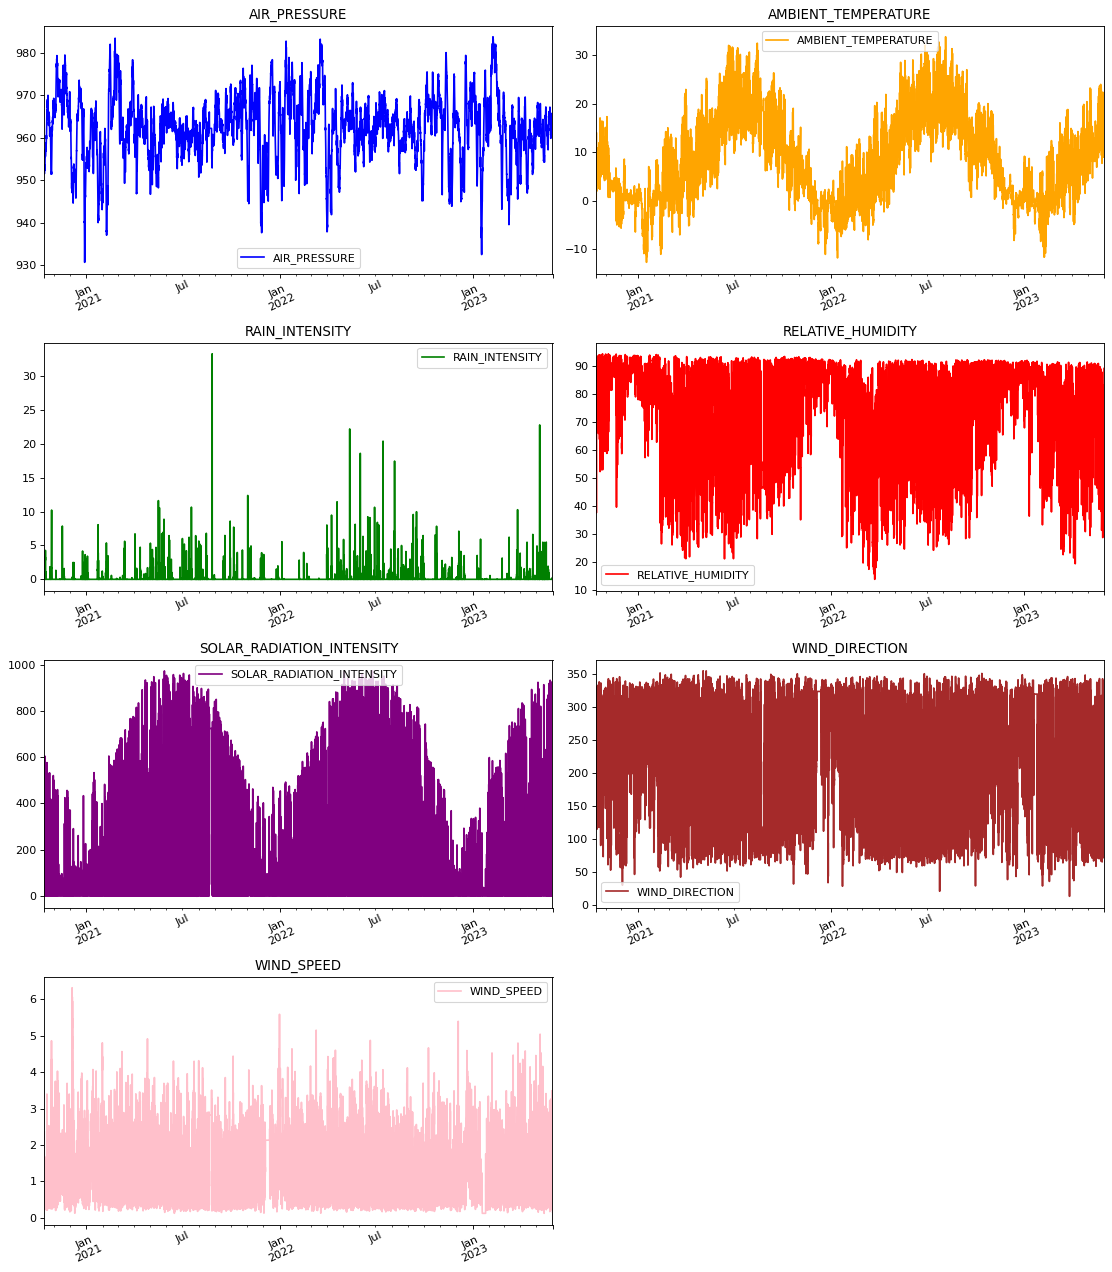

In [103]:
# plots

color_list=["blue","orange","green","red","purple","brown","pink"]

def Visualize(data):
    features=list(data.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)


   # create subplots with a flexible number of rows
    nrows = int(np.ceil(feature_size / 2))

    fig, axes = plt.subplots(
        nrows=nrows, ncols=2, 
        figsize=(14, nrows*4), dpi=80, facecolor='w', edgecolor='k'
    )
    
     # flatten the axes array for easy indexing
    if feature_size == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()


    # plot each feature
    for i in range(feature_size):
     key = features[i]
     c = color_list[i%(len(color_list))]
     t_data=data[key]
    
     ax=t_data.plot(
        ax=axes[i],
        color=c,
        title=key,
        rot=25,
     )
     ax.legend([key])
    

     # hide any unused subplots
    for j in range(feature_size, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()    

Visualize(new_data_all_resampled)    

In [104]:
# stationarity check

from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):
    

    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("Stationary")
    else:
        print("Non-stationary")

In [105]:
# ADF Test on each column
for name, column in new_data_all_resampled.items():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AIR_PRESSURE" 
    -----------------------------------------------
ADF Statistic: -12.645121
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "AMBIENT_TEMPERATURE" 
    -----------------------------------------------
ADF Statistic: -3.973137
p-value: 0.001558
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "RAIN_INTENSITY" 
    -----------------------------------------------
ADF Statistic: -41.532225
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "RELATIVE_HUMIDITY" 
    -----------------------------------------------
ADF Statistic: -9.509234
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "SOLAR_RADIATION_INTENSITY" 
    -----------------------------------------------
ADF Statist

In [106]:
print(new_data_all_resampled.index.dtype)

datetime64[ns, UTC]


In [107]:
# data for 2020, 2021, 2022
# fit the best model to this data
# forecast the next 24 hours 
# compare forecast from VAR and two simple models with actual values
# plot forecasts, plot errors

all_hourly_20_21_22 = new_data_all_resampled.loc[(new_data_all_resampled.index.year == 2020) | (new_data_all_resampled.index.year == 2021) | (new_data_all_resampled.index.year == 2022), ["AIR_PRESSURE", "AMBIENT_TEMPERATURE", "RAIN_INTENSITY", 
                                                 "RELATIVE_HUMIDITY", "SOLAR_RADIATION_INTENSITY", "WIND_DIRECTION", "WIND_SPEED"]]
#print(all_hourly_20_21_22)



In [108]:
# VAR model = Vector Auto-regression

# maybe this instead of ARIMA or both and compare?

# source: https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

# we checked before that all data is stationary so we dont have to difference it


from statsmodels.tsa.api import VAR

model = VAR(all_hourly_20_21_22)
results = model.fit(maxlags=15, ic='aic')

n_lags = results.k_ar # for later

print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Jun, 2024
Time:                     23:48:00
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    11.3695
Nobs:                     19415.0    HQIC:                   11.1672
Log likelihood:          -299547.    FPE:                    64126.9
AIC:                      11.0686    Det(Omega_mle):         61728.8
--------------------------------------------------------------------
Results for equation AIR_PRESSURE
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 3.150301         0.272690           11.553           0.000
L1.AIR_PRESSURE                       1.549110         0.007443          208.141      

In [109]:
# lets see the forecast (data is split into test (2023) and train (2020, 2021, 2022) datasets)
# fit the model to train
# compare the forecast with test
# maybe split it 3/4 train and 1/4 test? later
# first try it on ambient temperature

In [110]:
# data for 2023
# I will make a forecast for 1 day and compare it to actual data

all_hourly_23 = new_data_all_resampled.loc[(new_data_all_resampled.index.year == 2023), ["AIR_PRESSURE", "AMBIENT_TEMPERATURE", "RAIN_INTENSITY", 
                                                 "RELATIVE_HUMIDITY", "SOLAR_RADIATION_INTENSITY", "WIND_DIRECTION", "WIND_SPEED"]]
#print(all_hourly_23)

The time of the day also influences weather parameters so I will transform the datetime data with the sinus function in the way that at noon the value of sinus is 1 and at midnight it is -1. This will be another parameter used to find the best model fit and I will compare it to the definded VAR model without this sinusiodial time component. 

In [111]:
# transformation of time into sinus values: -1 is 00:00 and 1 is 12:00, so that the model will make better prediction by also taking the hour of the day into account
data_sinus = new_data_all_resampled
data_sinus['hour'] = data_sinus.index.hour
data_sinus['sinus_time'] = np.sin((data_sinus['hour'] / 24) * 2 * np.pi + np.pi / 2)
data_sinus.drop(columns=['hour'], inplace=True)
print(data_sinus)

                           AIR_PRESSURE  AMBIENT_TEMPERATURE  RAIN_INTENSITY  \
2020-10-13 10:00:00+00:00    952.762500             7.687500           0.000   
2020-10-13 11:00:00+00:00    952.366667             8.958333           0.000   
2020-10-13 12:00:00+00:00    951.783333            10.183333           0.000   
2020-10-13 13:00:00+00:00    951.691667            10.716667           0.000   
2020-10-13 14:00:00+00:00    951.508333            10.833333           0.000   
...                                 ...                  ...             ...   
2023-05-31 17:00:00+00:00    964.141667            18.708333           0.000   
2023-05-31 18:00:00+00:00    964.275000            17.141667           0.000   
2023-05-31 19:00:00+00:00    964.991667            15.525000           0.275   
2023-05-31 20:00:00+00:00    965.066667            14.341667           0.000   
2023-05-31 21:00:00+00:00    964.900000            13.983333           0.000   

                           RELATIVE_HUM

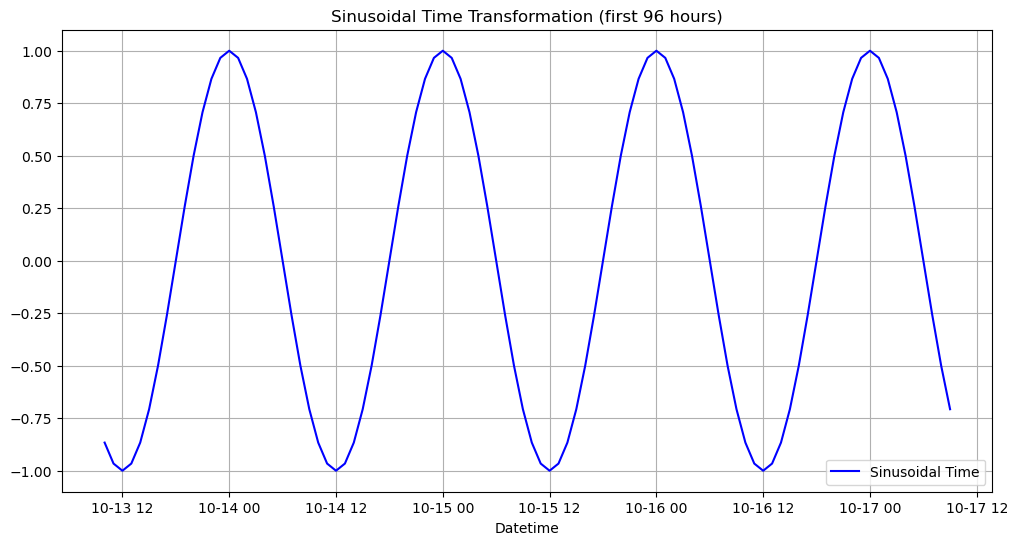

In [112]:
plt.figure(figsize=(12, 6))
plt.plot(data_sinus.index[:96], data_sinus['sinus_time'][:96], label='Sinusoidal Time', color='blue')
plt.xlabel('Datetime')
plt.title('Sinusoidal Time Transformation (first 96 hours)')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
# data for 2020, 2021, 2022

all_hourly_20_21_22_sinus = data_sinus.loc[(data_sinus.index.year == 2020) | (data_sinus.index.year == 2021) | (data_sinus.index.year == 2022), ["AIR_PRESSURE", "AMBIENT_TEMPERATURE", "RAIN_INTENSITY", 
                                                 "RELATIVE_HUMIDITY", "SOLAR_RADIATION_INTENSITY", "WIND_DIRECTION", "WIND_SPEED", "sinus_time"]]
#print(all_hourly_20_21_22_sinus)


In [114]:
# VAR model with sinusiodial time

from statsmodels.tsa.api import VAR

model_sinus = VAR(all_hourly_20_21_22_sinus)
results_sinus = model_sinus.fit(maxlags=15, ic='aic')

n_lags = results.k_ar # for later

print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Jun, 2024
Time:                     23:48:01
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    11.3695
Nobs:                     19415.0    HQIC:                   11.1672
Log likelihood:          -299547.    FPE:                    64126.9
AIC:                      11.0686    Det(Omega_mle):         61728.8
--------------------------------------------------------------------
Results for equation AIR_PRESSURE
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 3.150301         0.272690           11.553           0.000
L1.AIR_PRESSURE                       1.549110         0.007443          208.141      

In [ ]:
# data for 2023

all_hourly_23_sinus = data_sinus.loc[(data_sinus.index.year == 2023), ["AIR_PRESSURE", "AMBIENT_TEMPERATURE", "RAIN_INTENSITY", 
                                                 "RELATIVE_HUMIDITY", "SOLAR_RADIATION_INTENSITY", "WIND_DIRECTION", "WIND_SPEED", "sinus_time"]]
#print(all_hourly_23_sinus)

## Ambient Temperature

### VAR model

19430


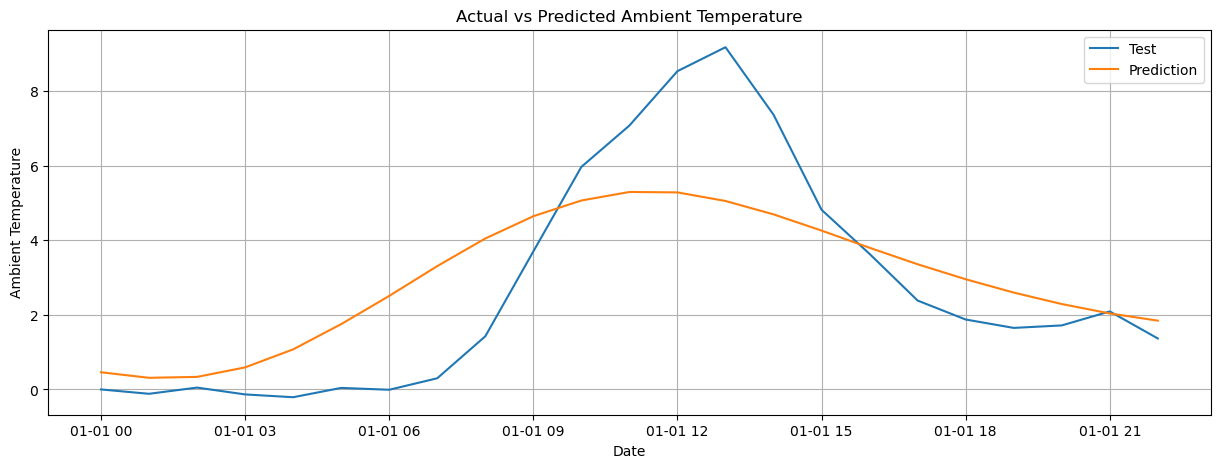

In [89]:
# AMBIENT TEMPERATURE

train_temp = all_hourly_20_21_22['AMBIENT_TEMPERATURE']
test_temp = all_hourly_23['AMBIENT_TEMPERATURE']
print(len(train_temp)) # 19430

lagged_values = all_hourly_20_21_22.values[-n_lags:]
pred = results.forecast(y=lagged_values, steps=24) 
pred_df = pd.DataFrame(pred, columns=all_hourly_20_21_22.columns)

plt.figure(figsize=(15, 5))
plt.grid()

plt.plot(all_hourly_23.index[:23], all_hourly_23['AMBIENT_TEMPERATURE'][:23], label='Test')

plt.plot(all_hourly_23.index[:23], pred_df['AMBIENT_TEMPERATURE'][:23], label='Prediction')

plt.legend()
plt.title('Actual vs Predicted Ambient Temperature')
plt.xlabel('Date')
plt.ylabel('Ambient Temperature')
plt.show()


In [90]:
# mean absolute error of the forecast

actual_values = all_hourly_23['AMBIENT_TEMPERATURE'][:24].values

predicted_values = pred_df['AMBIENT_TEMPERATURE'][:24].values

mae = np.mean(np.abs(actual_values - predicted_values))
print(f"Mean Absolute Error of VAR model forecast: {mae}")

Mean Absolute Error of VAR model forecast: 1.339075022424107


VAR model forecast absolute error:                           1.339075022424107

ARIMA(2,1,5) forecast absolute error:                        1.490556

ARIMA(4,1,2) forecast absolute error:                        1.474775

=> The mean absolute error of the forecast of VAR model is smaller than the ones from ARIMA.


### VAR model with sinusiodial time component

19430


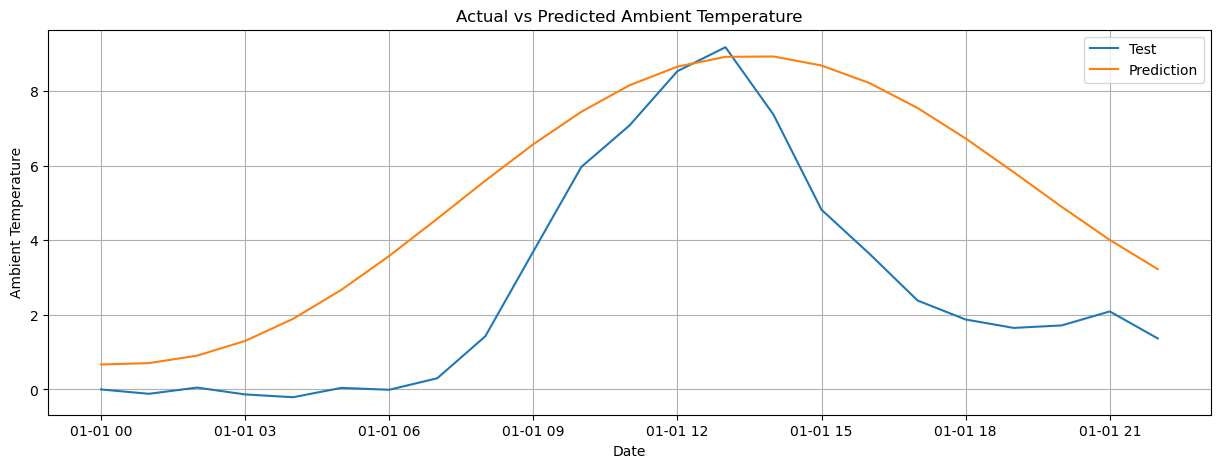

In [98]:
# AMBIENT TEMPERATURE

train_temp_sinus = all_hourly_20_21_22_sinus['AMBIENT_TEMPERATURE']
test_temp_sinus = all_hourly_23_sinus['AMBIENT_TEMPERATURE']
print(len(train_temp)) # 19430

lagged_values_sinus = all_hourly_20_21_22_sinus.values[-n_lags:]
pred_sinus = results_sinus.forecast(y=lagged_values_sinus, steps=24) 
pred_df_sinus = pd.DataFrame(pred_sinus, columns=all_hourly_20_21_22_sinus.columns)

plt.figure(figsize=(15, 5))
plt.grid()

plt.plot(all_hourly_23_sinus.index[:23], all_hourly_23_sinus['AMBIENT_TEMPERATURE'][:23], label='Test')

plt.plot(all_hourly_23_sinus.index[:23], pred_df_sinus['AMBIENT_TEMPERATURE'][:23], label='Prediction')

plt.legend()
plt.title('Actual vs Predicted Ambient Temperature')
plt.xlabel('Date')
plt.ylabel('Ambient Temperature')
plt.show()


In [100]:
# mean absolute error of the forecast of sinus VAR

actual_values_sinus = all_hourly_23_sinus['AMBIENT_TEMPERATURE'][:24].values

predicted_values_sinus = pred_df_sinus['AMBIENT_TEMPERATURE'][:24].values

mae = np.mean(np.abs(actual_values_sinus - predicted_values_sinus))
print(f"Mean Absolute Error of VAR model forecast: {mae}")

Mean Absolute Error of VAR model forecast: 2.458093476878387


VAR model with sinusiodial time component absolute forecast error: 2.458093476878387

VAR model forecast absolute error:                           1.339075022424107

ARIMA(2,1,5) forecast absolute error:                        1.490556

ARIMA(4,1,2) forecast absolute error:                        1.474775

=> Transforming time with the sinus function worsened the forecast results for ambient temperature, but from the plot it is visible that it captured the higher temperature around noon better.


## 